**의료 인공지능은 다양한 분야에서 사용됩니다. 질병의 정확한 분류 또는 환자의 중증도를 확인하는 용도 등 다양한 용도로 사용됩니다.<br><br>
이 중에서 현재 가장 핫한 분야는 질병을 탐지해내는 인공지능입니다. 이제 우리는 의사처럼 질병을 찾아내는 딥러닝 모델을 만들어보려고 합니다.<br>
우리가 할 것은 폐렴(Pneumonia)을 찾아내는 딥러닝 모델을 만드는 것입니다.<br>
이번 노드에서 사용할 데이터는 캐글의 Chest X-Ray Images 입니다.(중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5 세 소아 환자의 흉부 X선 영상)**

**Step 1. 실험환경 Set-up<br>
거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.**

In [279]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [280]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 20
EPOCHS = 30

print(ROOT_PATH)

/aiffel/aiffel


**Step 2. 데이터 준비하기<br>
원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.<br>
의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.**<br>

**이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.
그래서 augmentation 도입은 신중해야 합니다.**<br>

**만약 예를 들어 좌우 반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.**

In [281]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [282]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [283]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0582-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person313_bacteria_1457.jpeg


In [284]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1077
Pneumonia images count in training set: 3108


In [285]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [286]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [287]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [288]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [289]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [290]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [291]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [292]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

**Step 3. 데이터 시각화<br>
학습용 데이터를 시각화해서 확인해 봅니다.<br>
만약 augmentation을 시도했다면 이후 실습 코드에 있는 show_batch() 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인해 봅시다.**

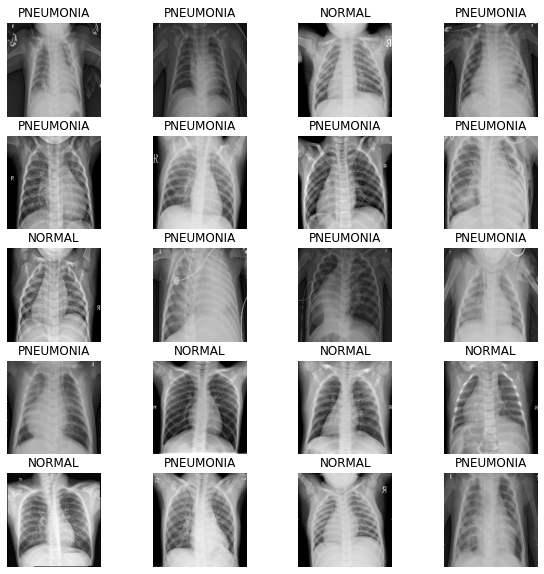

In [293]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

**Step 4. CNN 모델링<br>
의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.**<br>

**그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.<br>
이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료 영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.**

In [294]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [295]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [296]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

**Step 5. 데이터 imbalance 처리<br>
실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?**

In [297]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.94
Weight for PNEUMONIA: 0.67


**Step 6. 모델 훈련<br>
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.**

In [298]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [299]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
209/209 [==============================] - 41s 163ms/step - loss: 0.4833 - accuracy: 0.7469 - precision: 0.9367 - recall: 0.7005 - val_loss: 0.6394 - val_accuracy: 0.7404 - val_precision: 0.7404 - val_recall: 1.0000
Epoch 2/30
209/209 [==============================] - 33s 158ms/step - loss: 0.2225 - accuracy: 0.9089 - precision: 0.9754 - recall: 0.9012 - val_loss: 1.1182 - val_accuracy: 0.7385 - val_precision: 0.7385 - val_recall: 1.0000
Epoch 3/30
209/209 [==============================] - 33s 159ms/step - loss: 0.2078 - accuracy: 0.9273 - precision: 0.9736 - recall: 0.9264 - val_loss: 1.3864 - val_accuracy: 0.7404 - val_precision: 0.7404 - val_recall: 1.0000
Epoch 4/30
209/209 [==============================] - 34s 161ms/step - loss: 0.1658 - accuracy: 0.9371 - precision: 0.9792 - recall: 0.9351 - val_loss: 0.4576 - val_accuracy: 0.8038 - val_precision: 0.7903 - val_recall: 1.0000
Epoch 5/30
209/209 [==============================] - 33s 159ms/step - loss: 0.1887 - accura

**Step 7. 결과 확인과 시각화<br>
테스트 데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.**

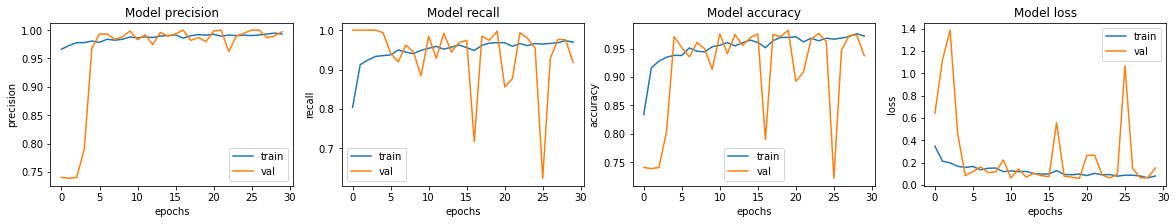

In [300]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [301]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

32/32 [==============================] - 3s 90ms/step - loss: 0.4297 - accuracy: 0.8734 - precision: 0.8542 - recall: 0.9615
Loss: 0.42970702052116394,
Accuracy: 0.8733974099159241,
Precision: 0.8542141318321228,
Recall: 0.9615384340286255


**다양하게 모델을 학습해본 결과 BATCH_SIZE = 20, EPOCHS = 30 일 때 87%라는 높은 정확성을 보였습니다.**